In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. 데이터 로드

In [3]:
file_path = "./dataset/TW.csv"
data = pd.read_csv(file_path)

# 2. 필요 컬럼 선택 및 전처리

In [5]:
data = data[['TIMESTAMP', 'VSL_ID', 'LAT', 'LON', 'COG', 'HEADING', 'SPEED', 'DESTINATION', 'UNLOCODE']]

# 3. 목적항 (DESTINATION) 인코딩 (예시: Label Encoding)

In [8]:
label_encoder = LabelEncoder()
data['DESTINATION'] = label_encoder.fit_transform(data['DESTINATION'])

# 4. 선박별 시계열 데이터 생성 (시퀀스 길이: 50)

In [10]:
def create_sequences(data, seq_length=50):
    sequences = []
    labels = []
    for vsl_id in data['VSL_ID'].unique():
        vessel_data = data[data['VSL_ID'] == vsl_id].sort_values(by='TIMESTAMP')
        
        # 시퀀스 생성
        for i in range(len(vessel_data) - seq_length):
            seq = vessel_data.iloc[i:i+seq_length][['LAT', 'LON', 'COG', 'HEADING', 'SPEED']].values
            label = vessel_data.iloc[i + seq_length]['DESTINATION']
            sequences.append(seq)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 5. 시계열 데이터 생성

In [12]:
X, y = create_sequences(data)

# 6. 학습용/검증용 데이터 분리

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# 7. LSTM 모델 구축

In [16]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # DESTINATION의 클래스 수만큼

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 8. 모델 컴파일

In [18]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 9. 모델 학습

In [20]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.1383 - loss: 304.2283 - val_accuracy: 0.4687 - val_loss: 1939.9728
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.3037 - loss: 305.7233 - val_accuracy: 0.4497 - val_loss: 1879.1807
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3261 - loss: 130.4010 - val_accuracy: 9.0662e-04 - val_loss: 1911.7527
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.3140 - loss: 126.7412 - val_accuracy: 0.3590 - val_loss: 2085.3511
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.3364 - loss: 102.5012 - val_accuracy: 0.4624 - val_loss: 2385.5498
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3469 - loss: 319.3268 - val_accuracy: 0.2312 - val_loss: 836.6212
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.3161 - loss: 129.6848 - val_accuracy: 0.1795 - val_loss: 425.9777
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - 

# 10. 예측 (예시: 검증 데이터에서 차기 도착항 예측)

In [24]:
predictions = model.predict(X_val)
predicted_ports = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


# 11. 예측 결과 확인

In [26]:
print(predicted_ports)

[nan nan nan ... nan nan nan]


In [34]:
# 모델 평가 (정확도 측정)
loss, accuracy = model.evaluate(X_val, y_val, batch_size=32)

# 결과 출력
print(f"Test Loss: {loss:.3f}") # 예측값과 실제값 사이의 차이
print(f"Test Accuracy: {accuracy:.3f}") # 예측 결과 간의 일치율

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4894 - loss: 8.9774
Test Loss: 12.086
Test Accuracy: 0.450


# 시각화

## 1. 모델 학습 과정 시각화 (Loss, Accuracy)

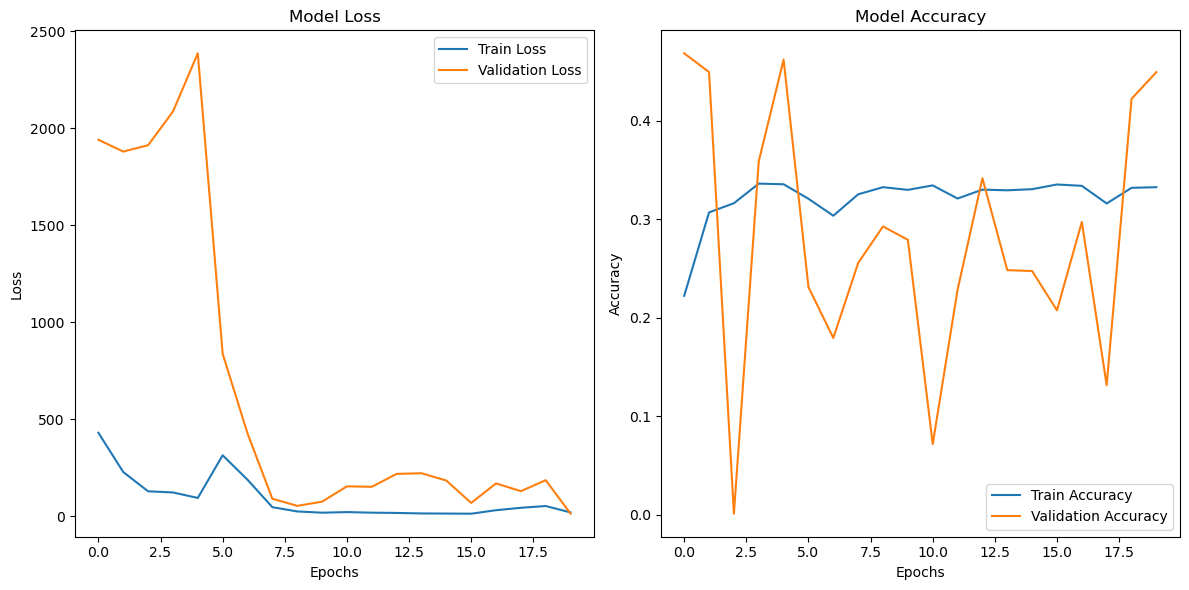

In [36]:
import matplotlib.pyplot as plt

# 학습 과정 시각화 (Loss, Accuracy)
def plot_training_history(history):
    # Loss 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화 함수 호출
plot_training_history(history)
